In [1]:
import numpy as np
import pylab as pl

from matplotlib.colors import ListedColormap
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression

from elm import GenELMClassifier
from random_layer import RBFRandomLayer, MLPRandomLayer

C:\Users\Vineeth\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def get_data_bounds(X):
    h = .02  # step size in the mesh

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    return (x_min, x_max, y_min, y_max, xx, yy)


def plot_data(ax, X_train, y_train, X_test, y_test, xx, yy):
    cm = ListedColormap(['#FF0000', '#0000FF'])
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm)
    # and testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm, alpha=0.6)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())


def plot_contour(ax, X_train, y_train, X_test, y_test, xx, yy, Z):
    cm = pl.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])

    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

    # Plot also the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
    # and testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())

    ax.set_title(name)
    ax.text(xx.max() - 0.3, yy.min() + 0.3, ('%.2f' % score).lstrip('0'),
            size=13, horizontalalignment='right')

In [3]:
def make_datasets():
    return [make_moons(n_samples=200, noise=0.3, random_state=0),
            make_circles(n_samples=200, noise=0.2, factor=0.5, random_state=1),
            make_linearly_separable()]


In [4]:
def make_classifiers():

    names = ["ELM(10,tanh)", "ELM(10,tanh,LR)", "ELM(10,sinsq)",
             "ELM(10,tribas)", "ELM(hardlim)", "ELM(20,rbf(0.1))"]

    nh = 10

    # pass user defined transfer func
    sinsq = (lambda x: np.power(np.sin(x), 2.0))
    srhl_sinsq = MLPRandomLayer(n_hidden=nh, activation_func=sinsq)

    # use internal transfer funcs
    srhl_tanh = MLPRandomLayer(n_hidden=nh, activation_func='tanh')

    srhl_tribas = MLPRandomLayer(n_hidden=nh, activation_func='tribas')

    srhl_hardlim = MLPRandomLayer(n_hidden=nh, activation_func='hardlim')

    # use gaussian RBF
    srhl_rbf = RBFRandomLayer(n_hidden=nh*2, rbf_width=0.1, random_state=0)

    log_reg = LogisticRegression()

    classifiers = [GenELMClassifier(hidden_layer=srhl_tanh),
                   GenELMClassifier(hidden_layer=srhl_tanh, regressor=log_reg),
                   GenELMClassifier(hidden_layer=srhl_sinsq),
                   GenELMClassifier(hidden_layer=srhl_tribas),
                   GenELMClassifier(hidden_layer=srhl_hardlim),
                   GenELMClassifier(hidden_layer=srhl_rbf)]

    return names, classifiers


In [6]:
def make_linearly_separable():
    X, y = make_classification(n_samples=200, n_features=2, n_redundant=0,
                               n_informative=2, random_state=1,
                               n_clusters_per_class=1)
    rng = np.random.RandomState(2)
    X += 2 * rng.uniform(size=X.shape)
    return (X, y)

###############################################################################

datasets = make_datasets()
names, classifiers = make_classifiers()

i = 1
figure = pl.figure(figsize=(18, 9))

# iterate over datasets
for ds in datasets:
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4,
                                                        random_state=0)

    x_min, x_max, y_min, y_max, xx, yy = get_data_bounds(X)

    # plot dataset first
    ax = pl.subplot(len(datasets), len(classifiers) + 1, i)
    plot_data(ax, X_train, y_train, X_test, y_test, xx, yy)

    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = pl.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will asign a color to each
        # point in the mesh [x_min, m_max]x[y_min, y_max].
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)

        plot_contour(ax, X_train, y_train, X_test, y_test, xx, yy, Z)

        i += 1

C:\Users\Vineeth\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


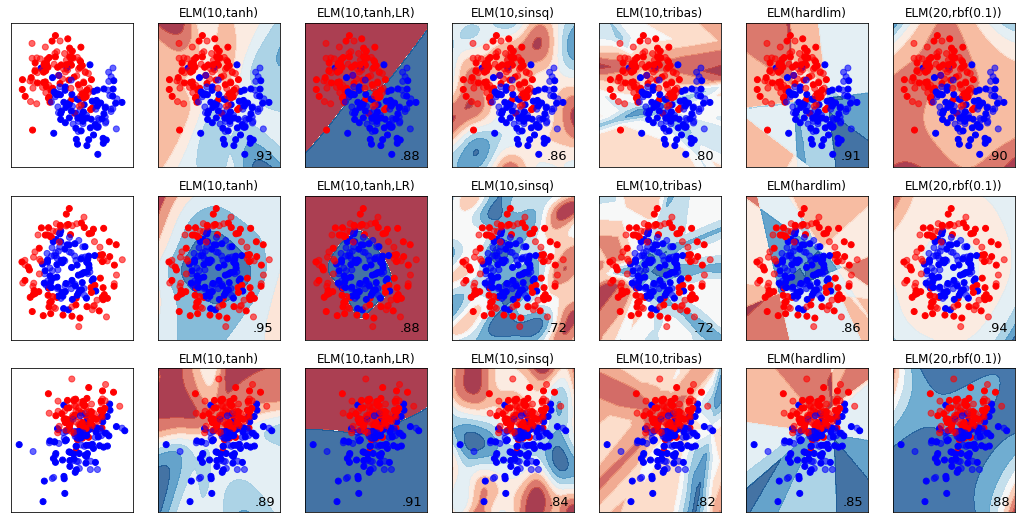

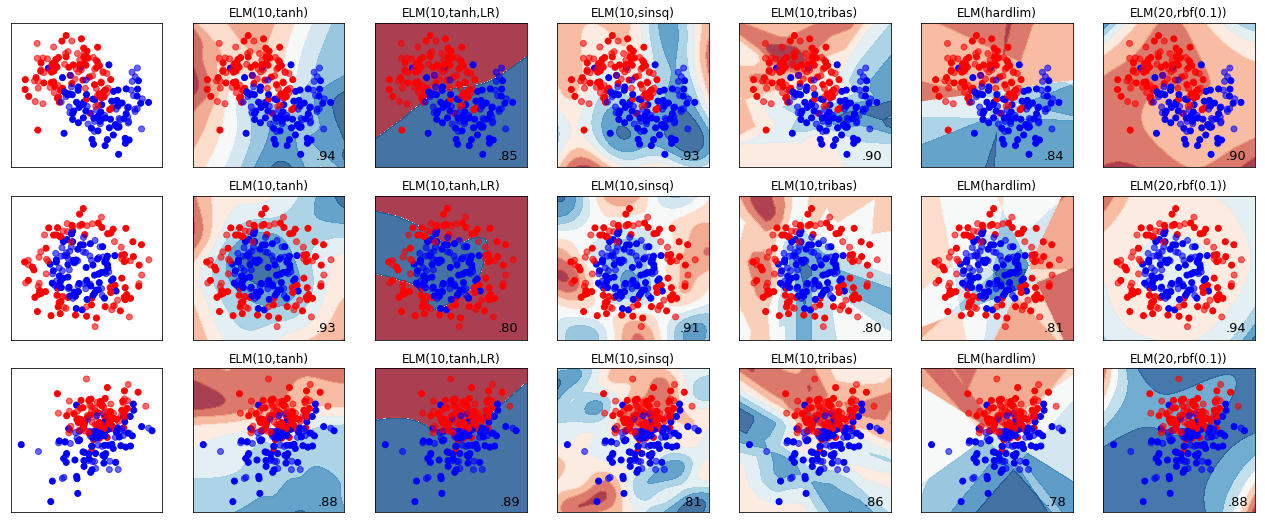

In [7]:
figure.subplots_adjust(left=.02, right=.98)
pl.show()